The Copernicus digital elevation model is derived from the WorldDEMTM digital surface model based on the radar satellite data acquired during the TanDEM-X Mission. The Planetary Computer hosts these data as Cloud Optimized GeoTIFFs in two resolutions, 90m and 30m.

For this example, we will find the DEM tile that includes the Grand Canyon and plot the elevation data with some hillshade.

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import odc.stac
import geopandas as gpd
import geopy.distance as distance
from shapely.geometry import Point
import rioxarray 
import xarray
import rasterio
import matplotlib.pyplot as plt
from rasterio import plot
import geopandas as gpd
from shapely.geometry import box
import datashader
import folium
from IPython.display import display
import cv2

%matplotlib inline


In [2]:
DATA_DIR = Path.cwd().parent.resolve() / "data"
assert DATA_DIR.exists()

In [3]:
metadata = pd.read_csv(DATA_DIR / "metadata.csv")
metadata.head()

uid   latitude   longitude        date  split
0  aabm  39.080319  -86.430867  2018-05-14  train
1  aabn  36.559700 -121.510000  2016-08-31   test
2  aacd  35.875083  -78.878434  2020-11-19  train
3  aaee  35.487000  -79.062133  2016-08-24  train
4  aaff  38.049471  -99.827001  2019-07-23  train

In [4]:
example_row = metadata[metadata.uid == "phbj"].iloc[0]
example_row

uid                phbj
latitude       42.21665
longitude    -109.37081
date         2021-07-26
split             train
Name: 13885, dtype: object

 find the DEM tile that includes the Grand Canyon and plot the elevation data with some hillshade.

In [5]:
#find the DEM tile that includes the Grand Canyon and plot the elevation data with some hillshade.
import pystac_client
import planetary_computer

catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

Perform a STAC API query against the finer resolution cop-dem-glo-30 collection for our point of interest.

In [6]:
lake_viva = [-112.15, 36.05]
search = catalog.search(
    collections=["cop-dem-glo-30"],
    intersects={"type": "Point", "coordinates":  [example_row.longitude,example_row.latitude, ]},
)
items = list(search.get_items())
print(f"Returned {len(items)} items")

Returned 1 items


A single item was returned which includes the elevation data and additional assets for quick visualization.

In [7]:
list(items[0].assets)

['data', 'tilejson', 'rendered_preview']

In [8]:
items[0]


<Item id=Copernicus_DSM_COG_10_N42_00_W110_00_DEM>

In [9]:
# get details of all of the items returned
item_details = pd.DataFrame(
    [
        {
            "datetime": item.datetime.strftime("%Y-%m-%d"),
            "platform": item.properties["platform"],
            "min_long": item.bbox[0],
            "max_long": item.bbox[2],
            "min_lat": item.bbox[1],
            "max_lat": item.bbox[3],
            "bbox": item.bbox,
            "item_obj": item,
        }
        for item in items
    ]
)

print(f"Filtering from {len(item_details)} returned to {item_details.sum()} items that contain the sample location")
item_details[["datetime", "platform", "bbox"]].sort_values(by="datetime")


Filtering from 1 returned to datetime                                           2021-04-22
platform                                             TanDEM-X
min_long                                          -110.000139
max_long                                          -109.000139
min_lat                                             42.000139
max_lat                                             43.000139
bbox        [-110.00013888888888, 42.00013888888889, -109....
item_obj    <Item id=Copernicus_DSM_COG_10_N42_00_W110_00_...
dtype: object items that contain the sample location


datetime  platform                                               bbox
0  2021-04-22  TanDEM-X  [-110.00013888888888, 42.00013888888889, -109....

In [10]:
# bbox2=item_details["bbox"].tolist()
# bbox2
# bbox=bbox2[0]
# bbox

In [11]:
# load the tile into an xarray after signing the HREF using planetary_computer.sign. Here we are downsampling the data to reduce the image size for this notebook.

import planetary_computer
import rioxarray

signed_asset = planetary_computer.sign(items[0].assets["data"])
data = (
    rioxarray.open_rasterio(signed_asset.href)
    .squeeze()
    .drop("band")
    .coarsen({"y": 5, "x": 5})
    .mean()
)

With the data loaded, we can use xarray-spatial to generate a shaded relief.

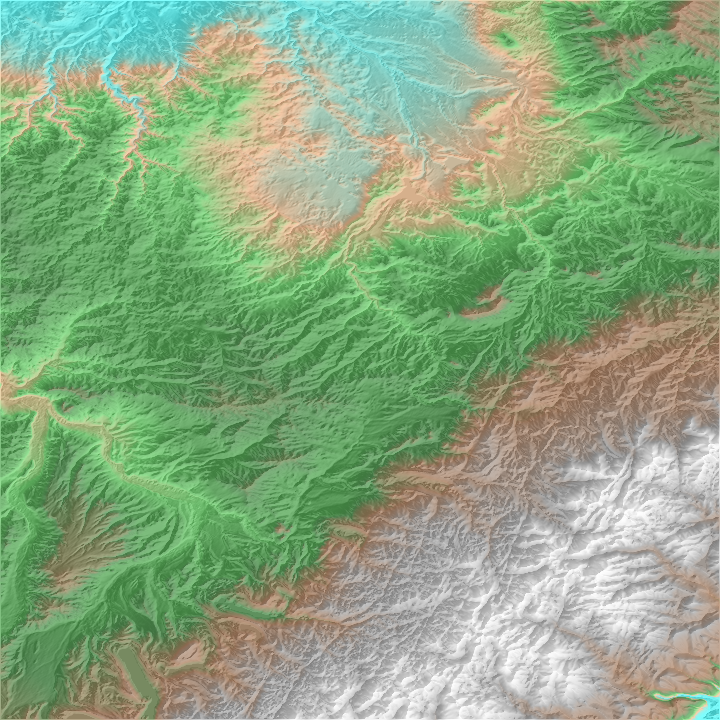

In [12]:
import xrspatial
from datashader.transfer_functions import shade, stack
from datashader.colors import Elevation

hillshade = xrspatial.hillshade(data)
stack(shade(hillshade, cmap=["white", "gray"]), shade(data, cmap=Elevation, alpha=128))

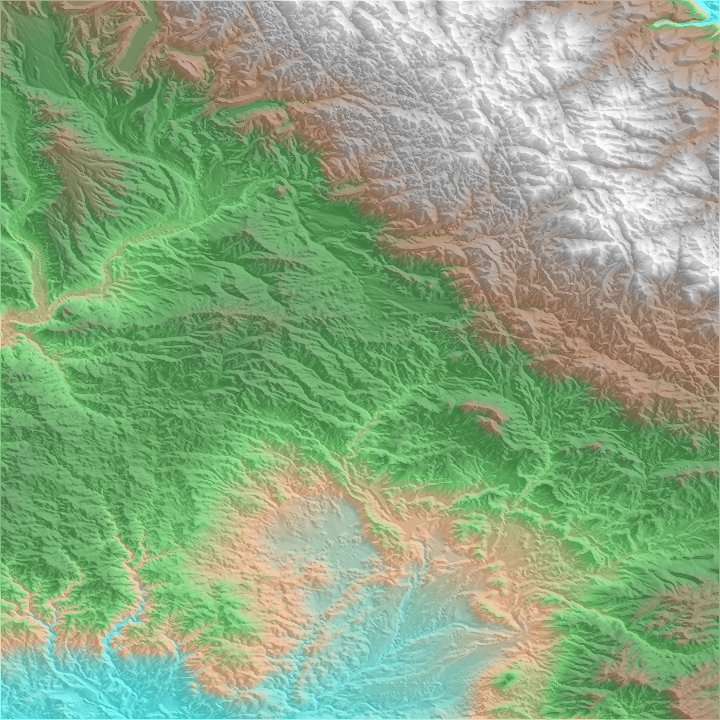

In [13]:
hillshade = xrspatial.hillshade(data)
stack(shade(hillshade, cmap=["white", "gray"]), shade(data[::-1, :], cmap=Elevation, alpha=128))

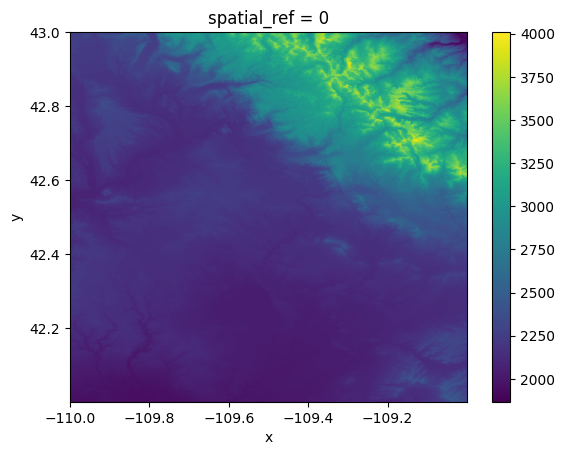

In [14]:
data.plot()

In [15]:
## clip using bounds in a CRS different from the dataset if you pass in the crs kwarg 
#xdsc = data.rio.clip_box(
#    minx=bbox[0],
#    miny=bbox[1],
#    maxx=bbox[2],
#    maxy=bbox[3],
#    crs="EPSG:4326"
#)
#xdsc.plot()

In [16]:
# get our bounding box to search latitude and longitude coordinates
def get_bounding_box(latitude, longitude, meter_buffer=50000):
    """
    Given a latitude, longitude, and buffer in meters, returns a bounding
    box around the point with the buffer on the left, right, top, and bottom.

    Returns a list of [minx, miny, maxx, maxy]
    """
    distance_search = distance.distance(meters=meter_buffer)

    # calculate the lat/long bounds based on ground distance
    # bearings are cardinal directions to move (south, west, north, and east)
    min_lat = distance_search.destination((latitude, longitude), bearing=180)[0]
    min_long = distance_search.destination((latitude, longitude), bearing=270)[1]
    max_lat = distance_search.destination((latitude, longitude), bearing=0)[0]
    max_long = distance_search.destination((latitude, longitude), bearing=90)[1]

    return [min_long, min_lat, max_long, max_lat]


bbox = get_bounding_box(example_row.latitude, example_row.longitude, meter_buffer=50000)
bbox

[-109.97635297809421,
 41.76649608583769,
 -108.7652670219058,
 42.666768463892325]

In [17]:
signed_asset = planetary_computer.sign(items[0].assets["data"])
data = (
    rioxarray.open_rasterio(signed_asset.href).rio.clip_box(
        minx=bbox[0],
        miny=bbox[1],
        maxx=bbox[2],
        maxy=bbox[3],
        crs="EPSG:4326",
    ).squeeze()
    .drop("band")
    .coarsen({"y": 5, "x": 5 }, boundary='pad')
    .mean()
)

In [18]:
def crop_sentinel_image(item, bounding_box):
    """
    Given a STAC item from Sentinel-2 and a bounding box tuple in the format
    (minx, miny, maxx, maxy), return a cropped portion of the item's visual
    imagery in the bounding box.

    Returns the image as a numpy array with dimensions (color band, height, width)
    """
    (minx, miny, maxx, maxy) = bounding_box

    image = rioxarray.open_rasterio(planetary_computer.sign(item.assets["data"].href)).rio.clip_box(
        minx=minx,
        miny=miny,
        maxx=maxx,
        maxy=maxy,
        crs="EPSG:4326",
    )

    return image.to_numpy()

In [19]:
# get a smaller geographic bounding box
minx, miny, maxx, maxy = get_bounding_box(example_row.latitude,example_row.longitude, meter_buffer=635 )

# get the zoomed in image array
bbox = (minx, miny, maxx, maxy)
zoomed_img_array = crop_sentinel_image(items[0], bbox)

zoomed_img_array[0]

array([[2044.5   , 2044.5   , 2044.5   , ..., 2044.5   , 2044.5   ,
        2044.5   ],
       [2044.5   , 2044.5   , 2044.5   , ..., 2044.5   , 2044.5   ,
        2044.5   ],
       [2044.5   , 2044.5   , 2044.5   , ..., 2044.5   , 2044.5   ,
        2044.5   ],
       ...,
       [2042.5094, 2043.0781, 2043.7275, ..., 2048.224 , 2049.7031,
        2050.0022],
       [2041.9946, 2042.8973, 2043.7386, ..., 2047.6572, 2048.38  ,
        2048.8977],
       [2042.0089, 2042.5753, 2043.2295, ..., 2047.7429, 2048.572 ,
        2049.0874]], dtype=float32)

In [20]:
bbox

(-109.3785005250809, 42.21093326743339, -109.36311947491912, 42.22236672684872)

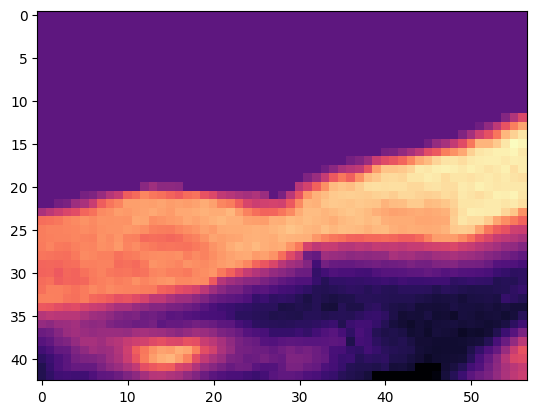

In [21]:
plt.imshow(np.transpose(zoomed_img_array, axes=[1, 2 , 0]), cmap='magma')

In [22]:
zoomed_img_array.shape

(1, 43, 57)

In [23]:
zoomed_img_array.min(), zoomed_img_array.max()

(2039.5, 2056.8945)

In [24]:
def normalize_elevation(arr):
    ''' Function to scale an input array to [0.0, 1.0] '''
    arr_min = -100 # lowest point: death valley
    arr_max = 4500 # highest point
    
    arr_range = arr_max - arr_min
    scaled = np.array((arr-arr_min) / float(arr_range), dtype='f')
    
    # limit values to 1.0
    scaled[scaled >= 1.0] = 1.0
    arr_new = ( (scaled)) 
    return arr_new

In [25]:
# scale pixel values into practical range
normalized = normalize_elevation(zoomed_img_array[0])
# upscale landsat images to same pixel size as sentinel
elevation_layer = np.array([cv2.resize(normalized, ( 128, 128), interpolation = cv2.INTER_AREA)])

In [26]:
elevation_layer.shape, elevation_layer.min(), elevation_layer.max()

((1, 128, 128), 0.4651087, 0.4688901)

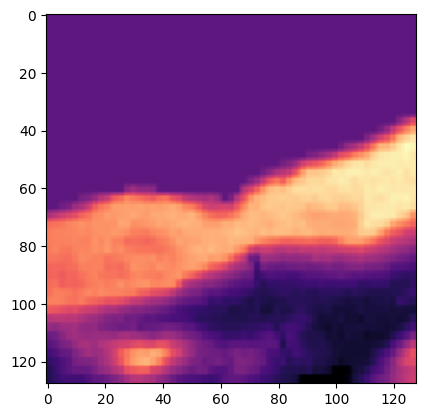

In [27]:
plt.imshow(np.transpose((elevation_layer), axes=[1, 2, 0]),cmap='magma')

In [28]:
#To plot the location on a map 
#import folium
#from IPython.display import display
#
#def plot_location_on_map(latitude, longitude):
#    m = folium.Map(location=[latitude, longitude], zoom_start=12)
#    folium.Marker([latitude, longitude]).add_to(m)
#    display(m)
#
#plot_location_on_map(41.9895, -110.6616)